In [1]:
import ast
import os
import re
from datetime import datetime as dt

import icecream
import jax.numpy as jnp
import numpy as np
import pandas as pd
from flax import nnx
from icecream import ic
from torch.utils.data import DataLoader

# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm, trange
from transformers import BertTokenizerFast, FlaxBertModel

import hephaestus as hp
import hephaestus.training as ht

icecream.install()
ic_disable = True  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model = FlaxBertModel.from_pretrained(model_name)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# Get the embeddings matrix
embeddings = model.params["embeddings"]["word_embeddings"]["embedding"]

# Now you can access specific embeddings like this:
# For example, to get embeddings for tokens 23, 293, and 993:
selected_embeddings = jnp.take(embeddings, jnp.array([23, 293, 993]), axis=0)

# If you want to get embeddings for specific words:
words = ["hello", "world", "example"]
tokens = tokenizer.convert_tokens_to_ids(words)
word_embeddings = jnp.take(embeddings, jnp.array(tokens), axis=0)
word_embeddings.shape

Some weights of FlaxBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: {('pooler', 'dense', 'kernel'), ('pooler', 'dense', 'bias')}
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(3, 768)

In [3]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [ ]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")


# Combine total mass of all planets into one column `planet<n>_m`
mass_regex = re.compile(r"planet(\d+)_m")
mass_cols = [col for col in df.columns if mass_regex.match(col)]
df["total_mass"] = df[mass_cols].sum(axis=1)
# df = df.reset_index(drop=True)
# Introduce categorical columns for the number of planets choose non null columns with mass
df["n_planets"] = df[mass_cols].notnull().sum(axis=1).astype("object")
df["n_planets"] = df["n_planets"].apply(lambda x: f"{x}_planets")
# Create category acceleration if the sum of plane/d_[x,y, z] is greater than 0
df["acceleration_x"] = df[
    [col for col in df.columns if "planet" in col and "_x" in col]
].sum(axis=1)
# Set acceleration_x to "increasing" if greater than 0 else "decreasing"
df["acceleration_x"] = (
    df["acceleration_x"]
    .apply(lambda x: "increasing" if x > 0 else "decreasing")
    .astype("object")
)
df["acceleration_y"] = df[
    [col for col in df.columns if "planet" in col and "_y" in col]
].sum(axis=1)
df["acceleration_y"] = df["acceleration_y"].apply(
    lambda x: "increasing" if x > 0 else "decreasing"
)


df.describe()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
count,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,4.165044e+06,4.165044e+06,5.563957e+06,5.563957e+06,...,2.783627e+06,2.783627e+06,2.783627e+06,2.783627e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,5.563957e+06
mean,6.248635e+04,9.748911e+00,-1.339198e-01,7.391138e-02,-1.340140e-01,7.291389e-02,-1.305344e-01,7.065633e-02,2.999306e+00,1.624756e+00,...,6.559150e-02,2.996303e+00,1.623874e+00,9.980576e-01,-1.276881e-01,6.519469e-02,3.002531e+00,1.625815e+00,1.001317e+00,1.049149e+01
std,3.607949e+04,5.993534e+00,1.228071e+00,1.213232e+00,1.227950e+00,1.212650e+00,1.217229e+00,1.203678e+00,1.157182e+00,5.876632e-01,...,1.200148e+00,1.153190e+00,5.270725e-01,5.764675e-01,1.211648e+00,1.199625e+00,1.156856e+00,5.167198e-01,5.779763e-01,3.991780e+00
min,0.000000e+00,0.000000e+00,-3.294763e+00,-2.997514e+00,-3.284004e+00,-2.998546e+00,-3.289790e+00,-2.998050e+00,1.000003e+00,1.000000e+00,...,-2.997621e+00,1.000054e+00,1.000000e+00,9.369537e-05,-3.273603e+00,-2.998913e+00,1.000103e+00,1.000000e+00,6.720938e-05,2.014597e+00
25%,3.124400e+04,4.655172e+00,-1.030131e+00,-9.020907e-01,-1.030516e+00,-9.028009e-01,-1.050662e+00,-9.211662e-01,1.993948e+00,1.000000e+00,...,-9.321272e-01,1.996853e+00,1.191548e+00,4.980967e-01,-1.071974e+00,-9.394428e-01,2.004240e+00,1.215927e+00,5.032645e-01,7.282371e+00
50%,6.249100e+04,9.523810e+00,-1.542335e-01,1.117099e-01,-1.538916e-01,1.099474e-01,-1.525520e-01,1.118031e-01,2.994477e+00,1.543047e+00,...,1.067355e-01,3.001879e+00,1.535683e+00,9.955040e-01,-1.507184e-01,1.055276e-01,3.000454e+00,1.519040e+00,1.003118e+00,1.028205e+01
75%,9.372800e+04,1.440000e+01,8.583344e-01,9.784987e-01,8.581045e-01,9.783998e-01,8.762358e-01,9.912902e-01,4.005747e+00,2.020672e+00,...,9.956064e-01,3.986406e+00,1.969644e+00,1.497746e+00,8.906780e-01,9.991220e-01,4.003332e+00,1.950518e+00,1.503457e+00,1.345633e+01
max,1.249990e+05,2.400000e+01,2.996370e+00,2.999014e+00,2.993319e+00,2.999536e+00,2.990464e+00,2.998478e+00,4.999994e+00,2.999984e+00,...,3.000881e+00,4.999990e+00,2.999909e+00,1.999957e+00,2.985180e+00,2.998936e+00,4.999679e+00,2.999497e+00,1.999999e+00,2.382455e+01


In [ ]:
df.head()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
1,0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
2,0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
3,0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
4,0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing


In [6]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['2_planets',
 '5_planets',
 'increasing',
 'decreasing',
 '4_planets',
 '3_planets']

In [ ]:
df.select_dtypes(include="object").groupby(
    df.select_dtypes(include="object").columns.tolist()
).size().reset_index(name="count")

,n_planets,acceleration_x,acceleration_y,count
0,2_planets,decreasing,decreasing,365720
1,2_planets,decreasing,increasing,410992
2,2_planets,increasing,decreasing,272240
3,2_planets,increasing,increasing,349961
4,3_planets,decreasing,decreasing,410092
5,3_planets,decreasing,increasing,404513
6,3_planets,increasing,decreasing,258536
7,3_planets,increasing,increasing,308276
8,4_planets,decreasing,decreasing,413451
9,4_planets,decreasing,increasing,416444


In [8]:
df = df.reset_index(drop=True)

In [9]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(99999, 25001)

In [10]:
def make_batch(ds: hp.TimeSeriesDS, start: int, length: int):
    numeric = []
    categorical = []
    for i in range(start, length + start):
        numeric.append(ds[i][0])
        categorical.append(ds[i][1])
    # print index of None values
    return {"numeric": jnp.array(numeric), "categorical": jnp.array(categorical)}


batch = make_batch(train_ds, 0, 4)
print(batch["numeric"].shape, batch["categorical"].shape)

# (4, 27, 59) (4, 3, 59)
# batch

(4, 27, 59) (4, 3, 59)


In [11]:
multiplier = 4
time_series_regressor = hp.TimeSeriesDecoder(
    time_series_config, d_model=1024, n_heads=8 * multiplier, rngs=nnx.Rngs(0)
)
# nnx.display(time_series_regressor)

In [12]:
res = time_series_regressor(
    numeric_inputs=batch["numeric"],
    categorical_inputs=batch["categorical"],
    deterministic=False,
)

In [13]:
res["numeric_out"].shape, res["categorical_out"].shape

((4, 27, 59), (4, 3, 59, 41))

In [14]:
if jnp.isnan(res["numeric_out"]).any():
    raise ValueError("NaN in numeric_out")
if jnp.isnan(res["categorical_out"]).any():
    raise ValueError("NaN in categorical_out")

In [15]:
ic.disable()

In [ ]:
metric_history = ht.create_metric_history()

learning_rate = 4e-3
momentum = 0.9
optimizer = ht.create_optimizer(time_series_regressor, learning_rate, momentum)

metrics = ht.create_metrics()
writer_name = "LowerRate"
# Get git commit hash for model name?
writer_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
commit_hash = hp.get_git_commit_hash()
model_name = f"{writer_time}_{writer_name}_{commit_hash}"
summary_writer = SummaryWriter("runs/" + model_name)


train_data_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
train_step = ht.create_train_step(
    model=time_series_regressor, optimizer=optimizer, metrics=metrics
)

for step, batch in enumerate(tqdm(train_data_loader)):
    batch = {"numeric": jnp.array(batch[0]), "categorical": jnp.array(batch[1])}
    train_step(time_series_regressor, batch, optimizer, metrics)
    for metric, value in metrics.compute().items():
        # Only shows `loss`

        metric_history[metric].append(value)
        if jnp.isnan(value).any():
            raise ValueError("Nan Values")
        summary_writer.add_scalar(f"train/{metric}", np.array(value), step)

    metrics.reset()

  0%|          | 0/6250 [00:00<?, ?it/s]

In [ ]:
df_comp = hp.show_results_df(
    model=time_series_regressor,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

In [ ]:
df_comp.output_df.loc[:, time_series_config.categorical_col_tokens].head()

,n_planets,acceleration_x,acceleration_y
0,37.0,34.0,34.0
1,37.0,34.0,34.0
2,37.0,34.0,34.0
3,37.0,34.0,34.0
4,37.0,34.0,34.0


In [ ]:
df_comp.output_df.loc[:, time_series_config.numeric_col_tokens].head()

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
1,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
2,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
3,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
4,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123


In [ ]:
# test_inputs = hp.AutoRegressiveResults.from_ds(train_ds, 0, 13)
test_inputs = hp.AutoRegressiveResults.from_ds(train_ds, 0, 13)

# inputs_test = train_ds[0]
# test_numeric = inputs_test[0]
# test_categorical = inputs_test[1]
# print(inputs_test.shape)
for i in trange(21):
    test_inputs, time_series_regressor = hp.auto_regressive_predictions(
        time_series_regressor, test_inputs
    )

# x = auto_regressive_predictions(state, test_ds[0], 10)

  0%|          | 0/21 [00:00<?, ?it/s]

In [38]:
auto_df = hp.create_test_inputs_df(test_inputs, time_series_config)

In [ ]:
auto_df.head(20)

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,34.0,34.0
1,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,34.0,34.0
2,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,34.0,34.0
3,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,34.0,34.0
4,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,34.0,34.0
5,2.325581,1.533811,0.905607,-1.000151,0.053178,-0.405638,2.868949,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,34.0,34.0
6,2.790698,1.335526,1.206832,-0.918192,-0.399688,-0.674529,2.825381,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,35.0,34.0
7,3.255814,1.087824,1.463513,-0.641980,-0.767958,-0.937474,2.756889,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,35.0,34.0
8,3.720930,0.801365,1.668203,-0.229808,-0.973515,-1.192211,2.664256,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,35.0,34.0
9,4.186047,0.487549,1.816168,0.231092,-0.972449,-1.436585,2.548458,1.312562,1.944263,1.897807,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974123,37.0,35.0,34.0


In [ ]:
res1 = time_series_regressor(
    numeric_inputs=jnp.array([train_ds[0][0][:, :10]]),
    categorical_inputs=jnp.array([train_ds[0][1][:, :10]]),
)


res_df = hp.create_non_auto_df(res1, time_series_config)
actual_df = hp.create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

0     1.560060
1     1.689858
2     1.753589
3     1.748068
4     1.673573
5     1.533811
6     1.335526
7     1.087824
8     0.801365
9     0.487549
10    0.157822
11   -0.176870
12   -0.506443
13   -0.506443
14   -0.506443
15   -0.506443
16   -0.506443
17   -0.506443
18   -0.506443
19   -0.506443
20   -0.506443
21   -0.506443
22   -0.506443
23   -0.506443
24   -0.506443
25   -0.506443
26   -0.506443
27   -0.506443
28   -0.506443
29   -0.506443
30   -0.506443
31   -0.506443
32   -0.506443
33   -0.506443
Name: planet0_x, dtype: float32

In [ ]:
hp.create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

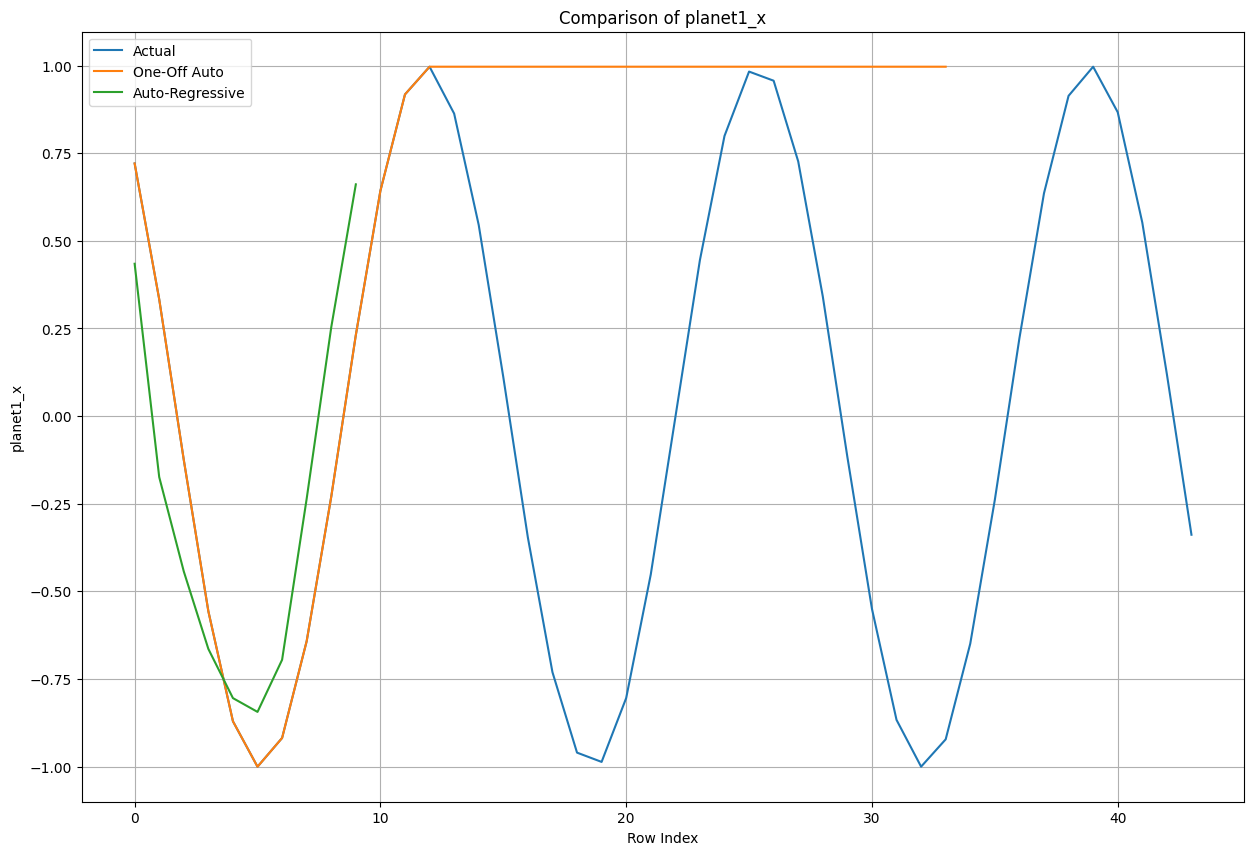

In [ ]:
hp.plot_comparison(actual_df, auto_df, res_df, "planet1_x")

In [33]:
import orbax.checkpoint as ocp

ckpt_dir = "/home/ubuntu/environment/Hephaestus/ckpts/test1"
_, state = nnx.split(time_series_regressor)
checkpointer = ocp.StandardCheckpointer()
checkpointer.save(ckpt_dir + "/state", state)

ERROR:absl:[process=0] Failed to run 1 Handler Commit operations or the Commit callback in background save thread, directory: /home/ubuntu/environment/Hephaestus/ckpts/test1/state
Traceback (most recent call last):
  File "/home/ubuntu/environment/Hephaestus/.venv/lib/python3.11/site-packages/orbax/checkpoint/_src/checkpointers/async_checkpointer.py", line 132, in _thread_func
    future.result()
  File "/home/ubuntu/environment/Hephaestus/.venv/lib/python3.11/site-packages/orbax/checkpoint/future.py", line 78, in result
    f.result(timeout=time_remaining)
  File "/home/ubuntu/environment/Hephaestus/.venv/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py", line 250, in result
    return self._t.join(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ubuntu/environment/Hephaestus/.venv/lib/python3.11/site-packages/orbax/checkpoint/future.py", line 62, in join
    raise self._exception
  File "/home/ubuntu/environment/Hephaestus/.venv

In [ ]:
import orbax.checkpoint as ocp
import jax
import jax.numpy as jnp
import nnx

# filepath: /home/ubuntu/environment/Hephaestus/Plannets.ipynb
ckpt_dir = "/home/ubuntu/environment/Hephaestus/ckpts/test1"
pure, state = nnx.split(time_series_regressor)


# Convert PRNGKey to a NumPy array
def convert_prng_keys_to_numpy(state):
    new_state = {}
    for key, value in state.items():
        if isinstance(value, jax.Array):
            new_state[key] = np.array(value)
        elif isinstance(value, dict):
            new_state[key] = convert_prng_keys_to_numpy(value)
        else:
            new_state[key] = value
    return new_state


state = convert_prng_keys_to_numpy(state)

checkpointer = ocp.StandardCheckpointer()
checkpointer.save(ckpt_dir + "/state", state)

ERROR:absl:[process=0] Failed to run 1 Handler Commit operations or the Commit callback in background save thread, directory: /home/ubuntu/environment/Hephaestus/ckpts/test1/state
Traceback (most recent call last):
  File "/home/ubuntu/environment/Hephaestus/.venv/lib/python3.11/site-packages/orbax/checkpoint/_src/checkpointers/async_checkpointer.py", line 132, in _thread_func
    future.result()
  File "/home/ubuntu/environment/Hephaestus/.venv/lib/python3.11/site-packages/orbax/checkpoint/future.py", line 78, in result
    f.result(timeout=time_remaining)
  File "/home/ubuntu/environment/Hephaestus/.venv/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py", line 250, in result
    return self._t.join(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ubuntu/environment/Hephaestus/.venv/lib/python3.11/site-packages/orbax/checkpoint/future.py", line 62, in join
    raise self._exception
  File "/home/ubuntu/environment/Hephaestus/.venv